## Particle in Cell method for the one-dimensional two-counterstreaming plasma

In [147]:
import numpy as np
import scipy.linalg as la

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import animation, rc
from IPython.display import HTML

Define the normalized/unitless constants

In [148]:
class Setup:
    def __init__(self, l, ns, nc, np, dt):
        self.length = l
        self.numSteps = ns
        self.numCells = nc
        self.numParticles = np
        self.cellSize = l/nc
        self.timeStep = dt

Setting up the arrays that will store the charge density, potential, and electric field in each cell; as well as arrays for storing particle positions and velocities. Assigning initial values for these quantities.

In [173]:
setupObj = Setup(1., 500, 45, 50, 0.5)
potentials = np.zeros((setupObj.numSteps, setupObj.numCells))
elfields = np.zeros((setupObj.numSteps, setupObj.numCells))
chargedensities = np.zeros((setupObj.numSteps, setupObj.numCells))

positions = np.zeros((setupObj.numSteps, setupObj.numParticles))
positions[0] = np.linspace(0, setupObj.length-setupObj.cellSize, setupObj.numParticles)

velocities = np.zeros((setupObj.numSteps, setupObj.numParticles))
initStreamVelocity = .1
velocities[0] = ((np.arange(setupObj.numParticles)%2)*2-1)*initStreamVelocity

totalMomentum = np.zeros(setupObj.numSteps)
totalKinEnergy = np.zeros(setupObj.numSteps)
totalPotEnergy = np.zeros(setupObj.numSteps)
totalEnergy = np.zeros(setupObj.numSteps)

Add small perturbations to the initial positions of particles to observe oscillatory modes in the plasma

In [174]:
# Attempt adding normally-distributed perturbations
normPertrubation_stddev = 0.2
# positions[1] += np.random.randn(setupObj.numParticles) * normPertrubation_stddev
# velocities[1] += np.random.randn(setupObj.numParticles) * 0.05

Main program loop (runs once for each simulation cycle, numSteps times)

In [175]:
for it in range(setupObj.numSteps-1):
    # Assign charge densities to cells (using nearest-neighbour approach)
    nearestCells = np.array(np.round(positions[it]/setupObj.cellSize), dtype=int)
    np.add.at(chargedensities[it], nearestCells, 1)
    chargedensities[it] /= setupObj.cellSize
    
    # Calculate the potentials
    potSolverMatrix = (np.diag(np.full(setupObj.numCells,-2.))
                       + np.diag(np.ones(setupObj.numCells-1),1)
                       + np.diag(np.ones(setupObj.numCells-1),-1))                
#     potSolverMatrix[0,-1]=1
#     potSolverMatrix[-1,0]=1
    potentials[it] = la.solve(potSolverMatrix, -chargedensities[it]*(setupObj.cellSize)**2)
    
    # Calculate the electric fields
    elfieldSolver = np.concatenate([[potentials[it,-1]], potentials[it], [potentials[it,0]]])
    elfields[it] = ((-0.5/setupObj.cellSize)
                    * (elfieldSolver[2:2+setupObj.numCells]-elfieldSolver[:setupObj.numCells]))
    # Calculate the electric fields at particle positions
    elfields_atparticles = nearestCells
    
    # Update velocities and positions (based on electric fields)
    velocities[it+1] = velocities[it] + setupObj.timeStep*elfields_atparticles
    positions[it+1] = positions[it] + setupObj.timeStep*velocities[it]
    positions[it+1] %= setupObj.length

After the simulation has run we gather the positions and velocities of the particles over time, so now we can animate the scenario (creates a javascript in-line video player for the simulation)

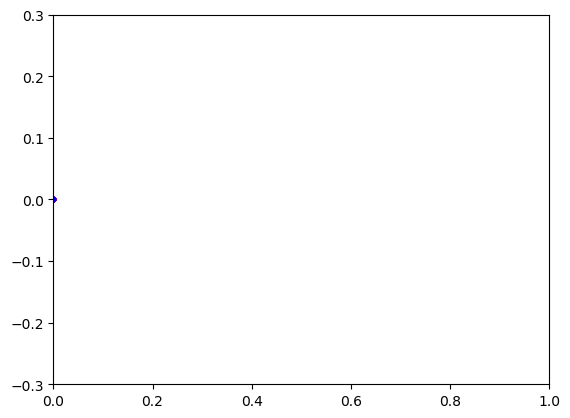

In [176]:
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['animation.embed_limit'] = 2**64

fig, ax = plt.subplots()
ax.set_xlim(0, setupObj.length)
ax.set_ylim(-initStreamVelocity*3, initStreamVelocity*3)
colors = np.array([('r' if i%2==0 else 'b') for i in range(setupObj.numParticles)])
scatterPlot = ax.scatter(0, 0, s=10.)

def animateStep(frame):
    scatterPlot.set_offsets(np.vstack([positions[frame],velocities[frame]]).T)
    scatterPlot.set_color(colors)
    return scatterPlot,

anim = animation.FuncAnimation(fig, 
                     func=animateStep, 
                     frames=np.arange(setupObj.numSteps), 
                     interval=setupObj.numSteps-1, 
                     blit=True)

# HTML(anim.to_jshtml())
Writer = animation.writers['ffmpeg']
writer = Writer(fps=20, metadata=dict(artist='Me'), bitrate=1800)
anim.save('TwoStreams_PICsimulation.mp4', writer=writer)

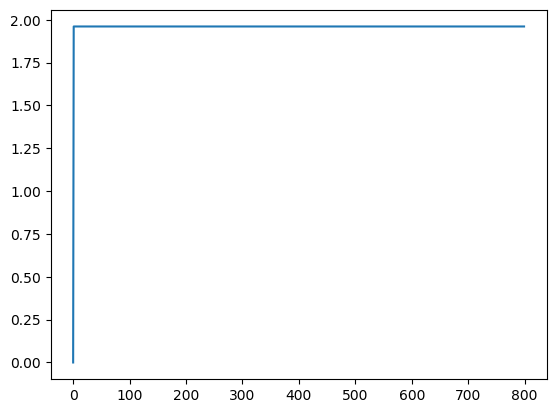

In [78]:
plt.plot(elfields[:,9])